In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import copy
import time
sns.set_theme()
from IPython.display import set_matplotlib_formats

In [2]:
from src.model import *

# Simulation des promotions d'un supermarché 

Création le 05/12/2022

## Introduction

Ce modèle fait référence au modèle proposé dans l'article "Comprendre l'impact des stratégies de prix sur le comportement des consommateurs". Dans ce modèle on représente un supermarché dans lequel on vend des biens de consommation courante. Les agents sont des entités (une personne, une famille etc.) représentant les clients, ayant chacun des paramètres internes uniques. 

Ce modèle ne prend pas en compte la géographie du magasin ni l'emplacement des produits. 

L'objectif de ce modèle est de fournir un outil de simulation reproduisant des faits marketings connus. L'objectif de ce notebook est de présenter le modèle et ses résultats.

### Les produits
Les produits sont des biens de consommation simple, disposant de 4 caractéristiques : un prix, une qualité, une quantité, et un booléen de promotion. On ajoute un nom afin de pouvoir les appeler plus simplement.

Ils sont instanciés via la classe Product(Nom,Prix,Qualité,Quantité). Le prix est un prix unitaire, la qualité un réel entre 0 et 1 et la quantité le nombre d'unités présentes dans le paquet. _"La quantité de produit est ici afin de créer des "packs" de différentes quantités. Pour chaque produit, il existe une quantité unitaire (en gramme, en ml, etc.) pour des raisons de simplicité, nous ne modélisons pas cette quantité unitaire, par contre, nous nous intéressons aux promotions des lots de produits."_


In [3]:
p0 = Product("Pâtes de marque X",2.3,0.5,2)

Le produit a un prix total et un prix à l'unité

In [4]:
p0.get_price_unit(),p0.get_price_total()

(2.3, 4.6)

Pour plus de réalisme les produits sont répartis en différentes catégories. Une catégorie représente un groupe de produits assez similaires pour qu'il soit rare qu'un client choisisse d'acheter 2 produits différents de la catégorie. Par exemple il est rare d'observer des achats de pâtes de même type mais de marques différentes. Cependant il n'est pas rare d'observer des achats de types de pâtes différents. Ainsi on pourrait créer plusieurs catégories de pâtes. 

Une catégorie de produit est instancié avec ProductsCategorie(nom,liste des produits). La création d'une catégorie nécéssite une liste de produits. (La liste de produits peut être vide, on ajoutera alors les produits après au fur et a mesur grace à la méthode add_product(produit)) 

In [5]:
cat = ProductsCategorie("test",[p0])
cat.show_products()

Nom :  Pâtes de marque X , Prix total :  4.6


0

In [6]:
P1 = Product("Pâtes de marque Y",1.6,0.4,4)
cat.add_product(P1)
cat.show_products()

Nom :  Pâtes de marque Y , Prix total :  6.4
Nom :  Pâtes de marque X , Prix total :  4.6


0

### L'environnement

L'environnement représente un supermarché, afin de l'instancier il faut une liste de catégories de produits. Nous disposons actuellement d'une catégorie de produit. Un magasin réaliste devrais contenir plusieurs catégories contenant plusieurs produits. Pour le moment une seul catégorie nous suffira. Un environnement est instancié avec Environment(Un liste de catégories de produits [cat1,cat2,...], le nombre d'agents, le nombre de pas de temps de simulation). Un environnement ne devrais jamais être vide (sans catégories). 

Les produits sont disponibles en quantité infinie. 

Le paramètre "nombre d'agents" génère un certains nombre d'agents aléatoirement dans l'environnement. Pour le moment nous allons créer un environnement sans agents et les ajouter après. 

In [7]:
mon_environnement = Environment([cat],0,10)

L'environnement dispose de quelque paramètre à initialiser, nous reviendrons sur l'impact de certains après pour le moment nous les initialisons à une valeur de référence prédéfinie (Donc pas besoin de passer les paramètres à l'environnement). L'environnement a besoin d'être réinitialiser à chaque nouvelle utilisation.

In [8]:
mon_environnement.initialise()

0

Si je lance une simulation maintenant, rien ne se passe car il n'y a pas d'agents. La méthode "revenues" permet d'obtenr le chiffre d'affaires du magasin sous la forme d'une liste

In [9]:
mon_environnement.run()
mon_environnement.revenues

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Nous allons ajouter les agents

### Les agents

Les agents représentent les clients. Sans supermarché pas de clients il faudra donc d'abord un environnement avant de pouvoir créer des agents. Un "client" est définit comme une entitée qui représente généralement une famille (un panier de courses) capable de faire des choix sur les produits dont il a besoin pour déterminer lesquels il va acheter. Un agent est instancié avec la méthode Agent(l'environnement, éventuellement un historique, éventuellement un profil)

In [10]:
mon_premier_agent = Agent("Mon 1er agent",mon_environnement)

Cet agent dispose d'un historique d'achats et d'un profil tiré aléatoirement. 
#### Les profils / sensibilités
Les profils pouvant être tirés sont les suivants : "Prix, Qualité, Promophile, Intertiel, Equilibré". Un profil de type "Prix" accorde beaucoup d'importance aux prix des produits, c'est l'équivalent d'un agent a petit budget. A l'invere un agent de type "Qualité" est un agent qui accorde beaucoup d'importance à la qualité, c'est l'équivalent d'un agent qui dispose d'un gros budget et est prêt à essayer des nouveaux produits si ceux-ci sont de bonne qualité. Ces profils suivent la même idée pour le profil "Promohpile", et "Inertiel" le profile equilibré accorde une importance a peu près similaire a tous ces attributs. Les profiles déterminent les sensibilités les "Beta_p,Beta_q,Beta_i,Beta_d" qui sont les paramètres qui modulent comment les agents évalue les produits et par conséquence ce que les agents choisissent comme produits.

In [11]:
mon_premier_agent.get_sensibility()

{'inertie': array([0.05161016]),
 'price': array([0.06634955]),
 'quality': array([0.8343505]),
 'promophile': array([0.04768979])}

On remarque que cet agent est un agent type "Prix" car sa sansibilité au prix est plus élevée que les autres.

Pour créer un profile personalisé il faut utiliser : Profile(liste des sensibilités) 
##### la liste des sensibilités est dans cette ordre: "Prix, Qualité, Inertie, Promopilie"
Au plus la valeur est élevée par rapport aux autre valeurs au plus l'agent accorde d'importance a ce paramètre. (Les valeurs passés sont normalisés de façon a ce que la somme fasse 1.)

In [12]:
mon_profil = Profile([100,10,6,100])
mon_profil.get_profile()

{'inertie': 0.027777777777777776,
 'price': 0.46296296296296297,
 'quality': 0.046296296296296294,
 'promophile': 0.46296296296296297}

Il suffit maintenant de passe ce profile a la création d'un nouvel agent. 

In [13]:
mon_agent_personalisé = Agent("Agent 2",mon_environnement,profile=mon_profil.get_profile())

### L'historique

L'historique représente les derniers achats d'un agent sur chaque catégorie de produit de l'environnement en type (quel produit) et en quantité (le nombre du produit acheté).
Voici un aperçu de l'historique généré aléatoirement des agents que nous avons crées. Les clés sont les différentes catégories.

In [14]:
mon_premier_agent.get_history()

({'test': [<src.model.Product at 0x7f60f3570d30>,
   <src.model.Product at 0x7f60f3570d30>]},
 {'test': array([ 7,  6, 12, 10,  5,  6,  8, 10,  3,  8,  5, 12, 11,  5,  8, 12,  8,
          4,  7,  4,  7,  3,  9,  9,  8,  3,  8, 10,  8, 12, 12,  9,  5,  6,
          3,  8,  4,  9,  3, 12,  8,  9, 12,  3,  7,  6,  7,  4,  9,  6])})

Pour réaliser un historique il y a 2 méthodes, History_gen(Catégories de produits, liste des Lambdas) et History (dict{catégorie1:achats,...},dict{catégorie1:quantité,....}). La première méthode génère un historique a partir de la liste des lambda de chaque catégorie. La seconde nécéssite un historique complet. 

In [15]:
H = History_gen([cat],10)

In [16]:
mon_second_agent_personalisé = Agent("Agent 3",mon_environnement,profile=mon_profil.get_profile(),history = H)

Ajoutons ces 3 agents à notre environnement. Attention a bien passer une liste en paramètre.

In [17]:
mon_environnement.add_agent([mon_premier_agent,mon_agent_personalisé,mon_second_agent_personalisé])

## La simulation

Maintenant nous disposons de tout ce dont nous avons besoin pour réaliser une simulation. La simulation peut être lancée plusieurs fois, un résultat différent devrait apparaître. Cela est du a l'aléatoire du modèle notamment dans le choix des agents, l'agent choisi un produit d'une catégorie selon une loi de probabilité propotionnel au score du produit. 

In [18]:
mon_environnement.initialise()
mon_environnement.run()
mon_environnement.revenues

array([63.2, 32.2, 45.8, 31.2, 36.8, 73.6,  0. , 93.6, 13.8, 54.2])

Voici les revenues/chiffre d'affaires qui correspond à : pour tous les agents (produits achetés * quantité acheté * prix) 
Pour mieux comprendre les mécanismes du modèle je vous propose d'afficher une trace de ce que nos agents ont pu acheter

In [19]:
mon_environnement.initialise()
mon_environnement.run(trace=True)
mon_environnement.revenues

Pas de temps num :  0  Agent :  Mon 1er agent  Besoin 7.44  Achat :  Pâtes de marque X Quantité :  3
Pas de temps num :  0  Agent :  Agent 2  Besoin 5.54  Achat :  Pâtes de marque X Quantité :  4
Pas de temps num :  0  Agent :  Agent 3  Besoin 8.88  Achat :  Pâtes de marque Y Quantité :  3
Pas de temps num :  1  Agent :  Mon 1er agent  Besoin 7.2  Achat : Rien Quantité : 0
Pas de temps num :  1  Agent :  Agent 2  Besoin 5.54  Achat :  Pâtes de marque X Quantité :  1
Pas de temps num :  1  Agent :  Agent 3  Besoin 8.7  Achat : Rien Quantité : 0
Pas de temps num :  2  Agent :  Mon 1er agent  Besoin 7.22  Achat :  Pâtes de marque X Quantité :  6
Pas de temps num :  2  Agent :  Agent 2  Besoin 5.58  Achat :  Pâtes de marque X Quantité :  4
Pas de temps num :  2  Agent :  Agent 3  Besoin 8.9  Achat :  Pâtes de marque Y Quantité :  5
Pas de temps num :  3  Agent :  Mon 1er agent  Besoin 7.12  Achat : Rien Quantité : 0
Pas de temps num :  3  Agent :  Agent 2  Besoin 5.72  Achat :  Pâtes de ma

array([51.4,  4.6, 78. , 27.6, 40.4, 46. , 25.6, 84.4,  0. , 63.4])

Voici pour la création d'un environnement basique. Maintenant nous allons générer un environnement plus dense (avec plus d'agents et de produits). Nous resterons sur des simulations avec une seul catégorie de produit car les catégories de produits ne s'influencent pas entre-elles. Cette influence est un développement futur auquel nous avons pensé. On pourrait imaginer par exemple qu'un achat de pâtes impact l'achat de riz, ou d'un autre type de pâtes. 

Créons d'abord une catégorie de produit contenant 9 produits. Nous avons choisi de faire 9 produits assez similaire notamment sur le ratio qualité/prix. C'est pour éviter l'apparition d'un "super produit", de meilleur qualité et moins cher que les autres, que tous les agents achèterais. Il est tout à fait possible de créer cette catégorie à la main ou de tout autre manière

In [55]:
base_price = np.random.randint(10, 100)
products = []
for j in range(3):
    price = base_price + np.random.normal(0,(base_price/4))   # On tire un prix de base aléatoire
    quality = np.random.normal((price/100),0.1)               # On tire une qualité proportionelle au prix
    for i in range(3):                                        # Création de 3 produits qu'on considerera d'une même marque (même qualité)
        products.append(Product(("Produit " + str(i+(j*3))), price, np.absolute(quality), 2 * (i+1)))
        price = price * 0.9                                   # On estime que le prix à l'unité est plus bas sur les produits vendu en grand quantité
Ma_categorie = ProductsCategorie("Ma_categorie", products)

Créons l'environnement

In [56]:
environnement_test = Environment([Ma_categorie],300,100)

In [57]:
environnement_test.initialise()

0

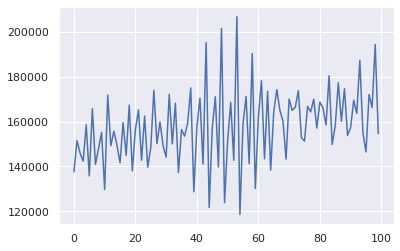

In [58]:
environnement_test.run()
plt.plot(environnement_test.revenues)

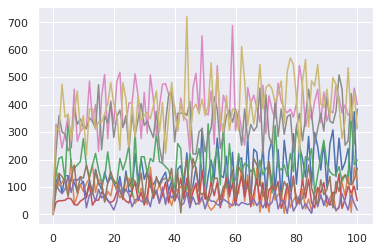

0

In [59]:
environnement_test.show_sales()

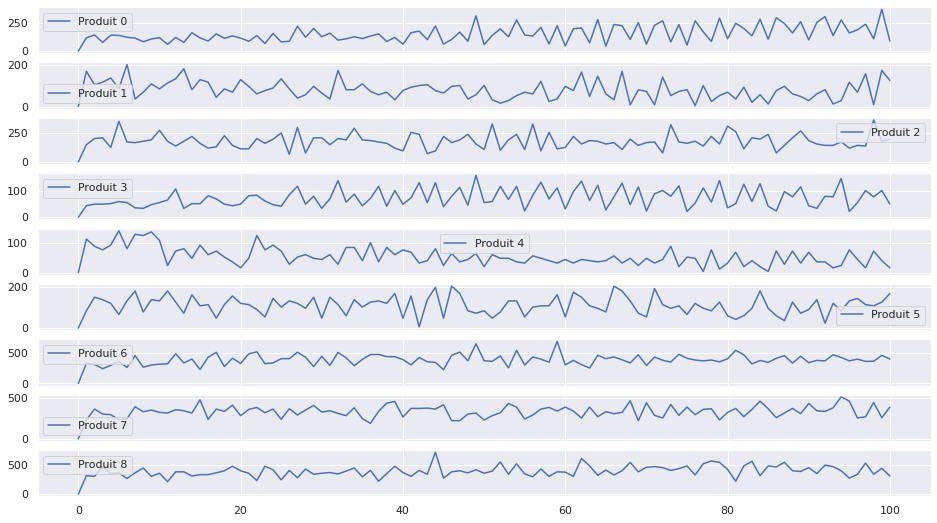

0

In [60]:
environnement_test.show_sales_separated()

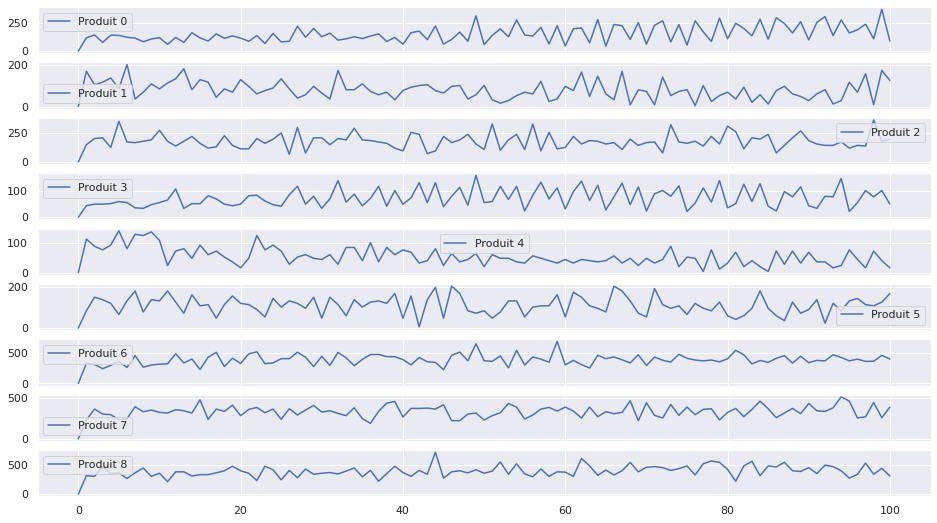

0

In [61]:
environnement_test.show_sales_separated()

## La promotion
Maintenant que nous avons pu voir toutes les étapes de la création de l'environnement et qu'il dispose de toutes les informations nécéssaires  nous allons pouvoir appliquer différentes promotions à notre modèle via la méthode de l'environnement make_promo(type de promotion, le pourentage de la promotion (si c'est une promotion en %), pas de temps du début de la prodmotion, pas de temps d'arrivée, le produit sur lequel faire la promotion). ce qui nous donne par exemple (0,40,(30,34),0,0)
: 0 pour une promotion en %, 40 pour 40% (30 pas de temps de départ, 34, pas de temps d'arrêt) et 0,0 pour la catégorie 0 produit 0

In [62]:
environnement_test.initialise()
environnement_test.make_promo((0,40,(30,34),0,0))
environnement_test.run()

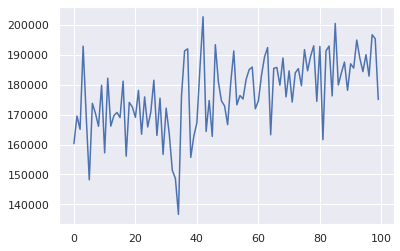

In [63]:
plt.plot(environnement_test.revenues)

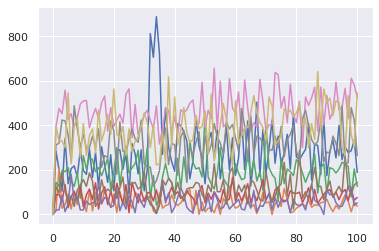

0

In [64]:
environnement_test.show_sales()

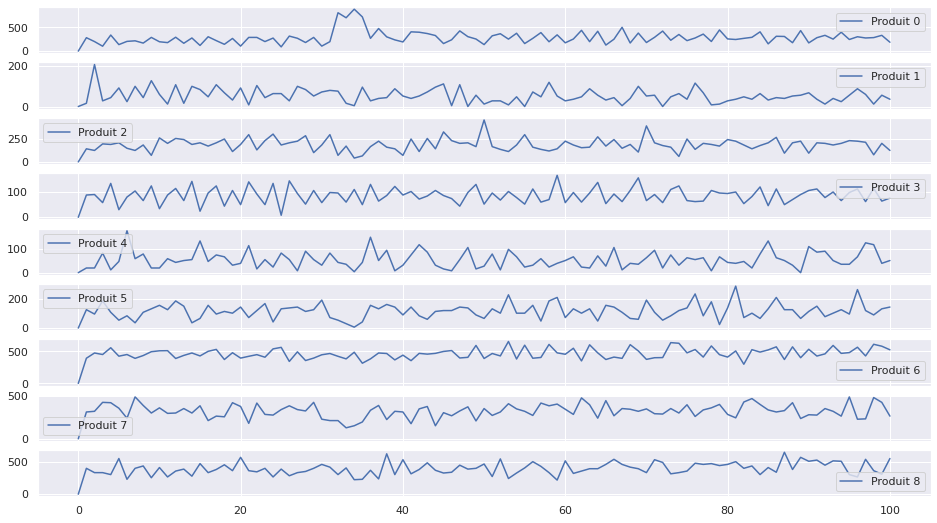

0

In [65]:
environnement_test.show_sales_separated()

On peut voir sur cette simulation que le produit 0 qui est le produit en promotion vois une forte augmentation de ses ventes durant la promotion. 
Afin de pouvoir observer l'impact des promotions plus préciséments nous allons comparer une même simulation avec et sans promotion. 

Afin d'avoir les mêmes agents dans chaque simulation pour la comparaison nous proposons de fixer la graine aléatoire. 

In [66]:
np.random.seed(3)
base_price = np.random.randint(10, 100)
products = []
for j in range(3):
    price = base_price + np.random.normal(0,(base_price/4))   # On tire un prix de base aléatoire
    quality = np.random.normal((price/100),0.1)               # On tire une qualité proportionelle au prix
    for i in range(3):                                        # Création de 3 produits qu'on considerera d'une même marque (même qualité)
        products.append(Product(("Produit " + str(i+(j*3))), price, np.absolute(quality), 2 * (i+1)))
        price = price * 0.9                                   # On estime que le prix à l'unité est plus bas sur les produits vendu en grand quantité
Ma_categorie = ProductsCategorie("Ma_categorie", products)

In [67]:
np.random.seed(3)
environnement_promo = Environment([Ma_categorie],300,100)
np.random.seed(3)
environnement_sans_promo = Environment([Ma_categorie],300,100)

In [68]:
environnement_promo.initialise()
environnement_promo.make_promo((0,40,(30,34),0,0))
environnement_sans_promo.initialise()

0

In [69]:
environnement_promo.run()
environnement_sans_promo.run()

Si on veut, il est possible d'afficher les résultats sur une même figure de cette manière :

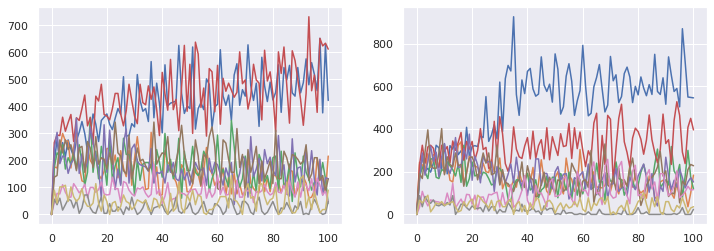

In [70]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(environnement_sans_promo.get_sales())
axs[1].plot(environnement_promo.get_sales())

On peut observer le pic des ventes du produit 0 (en bleu) au moment de la promotion ainsi qu'une certaine fidélisation. De plus nous il ne faut pas oublier que maintenant nous avons fixé une graine aléatoire, les résutats si le code est le même, seront inchangé malgrés l'aléatoire du modèle. 

## Un test plus simple pour la guerre des prix

On génère 2 produits assez similaires, un porté sur la qualité, l'autre sur le prix. On peut aussi imaginer deux produits très différents en terme de prix/qualité ou encore 2 produits encore plus similaires. Ces caratéristiques auront un impact sur les courbes que nous allons observer. Le but ici est de présenter une guerre des prix, avec des baisses successives du prix des produits. 

Dans un premier temps la méthode Environment.get_favorites() permet de récupérer pour chaque produit le nombre d'agent ayant pour favorit le produit. Un agent a pour produit favori celui qu'il le plus acheté dans l'historique de l'agent. Voici comment utiliser get_favorites():

In [71]:
#On fait la simulation
cat_0 = ProductsCategorie("catégorie 0",[Product("Produit_A", 10, 0.5, 1), Product("Produit_B", 12, 0.7, 1)])
envrionnement_price_war = Environment([cat_0],300,10)
envrionnement_price_war.initialise()
envrionnement_price_war.run()
#On récupère les informations
results = envrionnement_price_war.get_favorites()
results

{'Produit_A': [144, 136, 132, 130, 123, 123, 109, 105, 96, 92],
 'Produit_B': [156, 164, 168, 170, 177, 177, 191, 195, 204, 208]}

Il ne reste plus qu'à afficher les résultats.

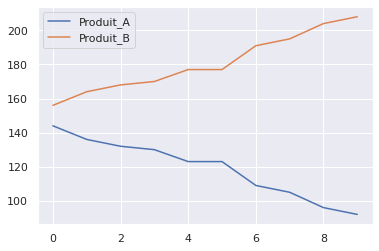

In [72]:
plt.plot(results['Produit_A'],label='Produit_A')
plt.plot(results['Produit_B'],label='Produit_B')
plt.legend()

Une autre manière d'afficher si il y a plus de produits par exemple

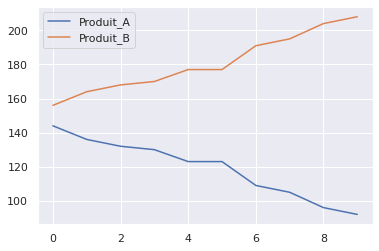

In [73]:
for k in results.keys():
    plt.plot(results[k],label=k)
plt.legend()

On relance une simulation avec des produits différents pour illustrer le fait qu'avec seulement 2 produits en concurence direct leurs paramètres ont une grand importance. 

De plus il ne faut pas oublier la prise en compte des paramètres globaux dont on parlera dans la prochaine section pouvant faire varier l'importance du prix ou de la qualité. 

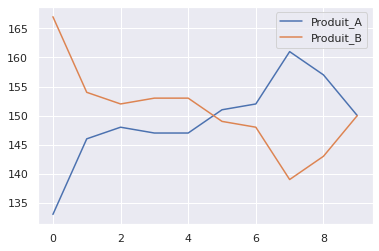

In [74]:
cat_0 = ProductsCategorie("catégorie 0",[Product("Produit_A", 6, 0.6, 1), Product("Produit_B", 24, 0.7, 1)])
envrionnement_price_war = Environment([cat_0],300,10)
envrionnement_price_war.initialise()
envrionnement_price_war.run()
#On récupère les informations
results = envrionnement_price_war.get_favorites()
results
for k in results.keys():
    plt.plot(results[k],label=k)
plt.legend()

Nous allons réaliser des simulations de 100 pas de temps à graine aléatoire fixé (pour la comparaison)

Maintenant nous allons réaliser une simulation un peu plus longue sans changement de prix.

In [75]:
np.random.seed(42)
#On fait la simulation
cat_0 = ProductsCategorie("catégorie 0",[Product("Produit_A", 100, 0.5, 1), Product("Produit_B", 120, 0.6, 1)])
envrionnement_price_war = Environment([cat_0],300,100)
envrionnement_price_war.initialise()
envrionnement_price_war.run()
#On récupère les informations
chiffreAffaires = envrionnement_price_war.revenues
favoris = envrionnement_price_war.get_favorites()

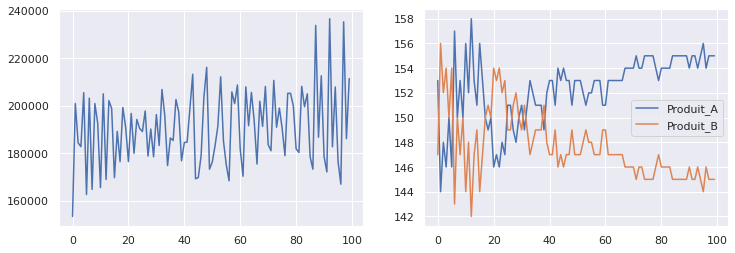

In [76]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

Nouvelle simulation avec une baisse du prix uniquement du produit A

Un changement de prix s'effectue avec la méthode reduce_price(pourcentage, tick d'effet, le produit) ou raise_price(pourcentage, tick d'effet, le produit). ce qui donne par exemple reduce_price(20, 30, 0, 0)

In [77]:
np.random.seed(42)
#On fait la simulation
cat_0 = ProductsCategorie("catégorie 0",[Product("Produit_A", 100, 0.5, 1), Product("Produit_B", 120, 0.6, 1)])
envrionnement_price_war = Environment([cat_0],300,100)
envrionnement_price_war.initialise()
#On indique à quel moment à lieu la baisse de prix ()
envrionnement_price_war.reduce_price(40, 30, 0, 0)
envrionnement_price_war.run()
#On récupère les informations
chiffreAffaires = envrionnement_price_war.revenues
favoris = envrionnement_price_war.get_favorites()

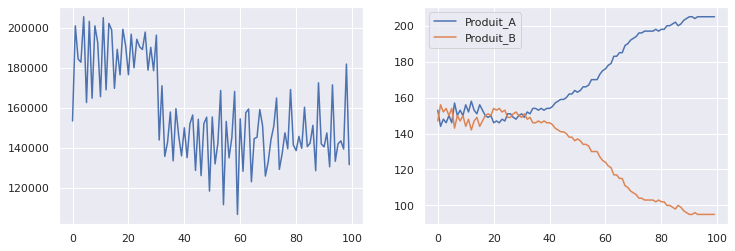

In [78]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

Finalement on réalise une simulation avec ce qu'on entend par guerre des prix, c'est à dire, le prix du produit B baisse ce qui entraine une baisse du prix du produit A ce qui entraine une baisse du produit B etc. 

In [79]:
np.random.seed(42)
#On fait la simulation
cat_0 = ProductsCategorie("catégorie 0",[Product("Produit_A", 100, 0.5, 1), Product("Produit_B", 120, 0.6, 1)])
envrionnement_price_war = Environment([cat_0],300,100)
envrionnement_price_war.initialise()
#On indique à quel moment à lieu la baisse de prix ()
envrionnement_price_war.reduce_price(20, 10, 0, 0)
envrionnement_price_war.reduce_price(20, 20, 0, 1)
envrionnement_price_war.reduce_price(20, 30, 0, 0)
envrionnement_price_war.reduce_price(20, 40, 0, 1)
# envrionnement_price_war.reduce_price(20, 50, 0, 1)
# envrionnement_price_war.reduce_price(20, 60, 0, 1)
envrionnement_price_war.run()
#On récupère les informations
chiffreAffaires = envrionnement_price_war.revenues
favoris = envrionnement_price_war.get_favorites()

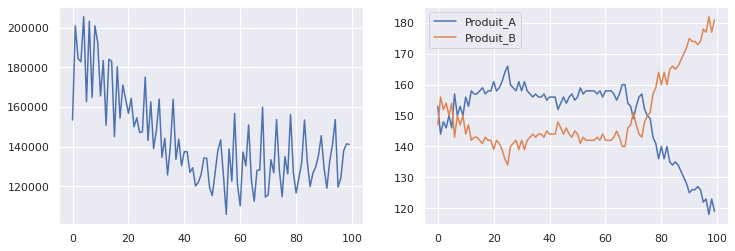

In [80]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(chiffreAffaires)
for k in favoris.keys():
    axs[1].plot(favoris[k],label=k)
axs[1].legend()

## Les paramètres du modèle
Le modèle dispose de 7 paramètres : prix, qualité, promophile, sat_alpha, phi, c, inertie. 
Prix qualité promophile et inertie sont des paramètres que gèrent l'importance global pour les agents du prix de la qualité de la promotion et de l'inertie.

Un prix à 1 avec les autres valeurs à 0 signifierais que les agents prennent tous uniquement en compte le prix des produits pour déterminer leurs achats.

sat_alpha correspond au paramètre de régulation de la pente de la fonction de saturation (utilisé dans le calcul de la quantité). Plus il est élevé plus la pente est douce et inverssement. C est la borne supérieur de cette fonction de saturation.

Finalement Phi correspond a l'intensité de l'aversion à a perte. Phi = 0.5 équivaut à ce que perdre 1€ impact négativement un agent 1.5 fois plus que de gagner 1€ l'impact positivement. Phi = 2 correspondrait a ce même ratio égal à 3.

Jusqu'a maintenant les paramètres étaient initialisé a ces valeurs : price=0.5, quality=100, promophile=5, sat_alpha=100, phi=0.3, c = 2, inertia = 2 choisies arbitrairement. 

Les 4 paramètres globaux prix qualité promotion et inertie sont multipliés par les valeurs des produits lors des évaluations. Ainsi ces paramètres globaux régulent l'importance de chaque effet.

Par exemple le prix étant dans nos exemples ci-dessus était environ égal à 100, la qualité comprise en entre 0 et 1 la promotion égal soit à 0 soit 1 et l'inertie ayant une valeur compris entre -4 et 20. 

Ces valeurs multipliées par nos paramètres globaux on obtiens (50, [0,100], (0 ou 5), [-8,40]). Ce sont des valeurs plus proches les unes des autres, nos paramètres globaux viennent donc bien équilibrer l'impact du prix de la qualité de la promotion et de l'inertie. Il permettent aussi de jouer sur le comportement de tous les agents afin d'exacerber certains comportements.

#### C et alpha_sat
Pour mieux comprendre les valeurs alpha_sat et c je vous propose d'afficher la fonction de saturation selon ces valeurs.

In [81]:
def sat(U,alpha,c):
        x = (U)
        y = math.log(c-1)
        return c / (1 + math.exp(-x/alpha+y))

Text(0, 0.5, 'Multiplicateur de quantité')

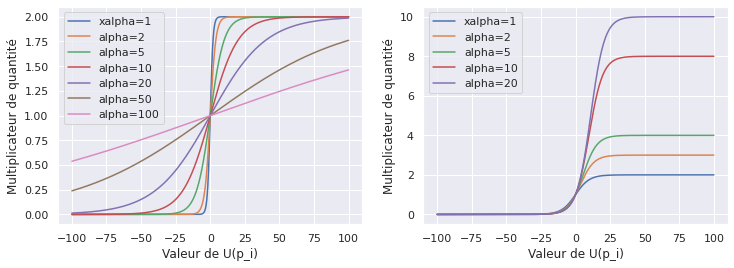

In [82]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
for alpha in [1,2,5,10,20,50,100]:
    c=2
    res = np.array(np.zeros(len(np.arange(-100,100,0.01))))
    cpt = 0
    for i in np.arange(-100,100,0.01):
        res[cpt] = sat(i,alpha,c)
        cpt+=1
    axs[0].plot(np.arange(-100,100,0.01),res)
axs[0].legend(("xalpha=1","alpha=2","alpha=5","alpha=10","alpha=20","alpha=50","alpha=100") )
axs[0].set_xlabel("Valeur de U(p_i)")
axs[0].set_ylabel("Multiplicateur de quantité")
for c in [2,3,4,8,10]:
    alpha = 5
    res = np.array(np.zeros(len(np.arange(-100,100,0.01))))
    cpt = 0
    for i in np.arange(-100,100,0.01):
        res[cpt] = sat(i,alpha,c)
        cpt+=1
    axs[1].plot(np.arange(-100,100,0.01),res)
axs[1].legend(("xalpha=1","alpha=2","alpha=5","alpha=10","alpha=20","alpha=50","alpha=100") )
axs[1].set_xlabel("Valeur de U(p_i)")
axs[1].set_ylabel("Multiplicateur de quantité")

#### Simulations pour différents paramètres

Voici quelque exemples de changements de paramètres. On reprend la catégorie de produit à 8 produits utilisée précedemment. 

In [83]:
environnement_test = Environment([Ma_categorie],300,100)

Les paramètres de l'evironnement sont passés via la méthode initialise() 
Les paramètres sont price, quality, promophile, sat_alpha, phi, c, inertia

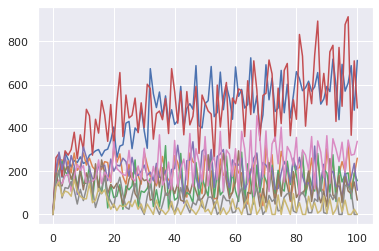

0

In [84]:
environnement_test.initialise(inertia = 10)
environnement_test.make_promo((0,40,(30,34),0,0))
environnement_test.run()
environnement_test.show_sales()

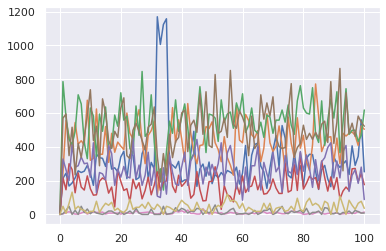

0

In [85]:
environnement_test.initialise(inertia = 0)
environnement_test.make_promo((0,40,(30,34),0,0))
environnement_test.run()
environnement_test.show_sales()

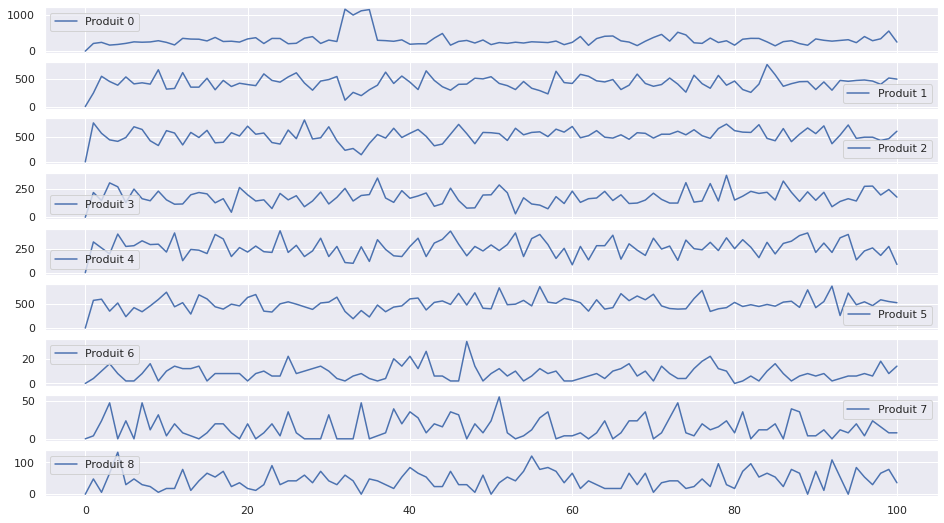

0

In [86]:
environnement_test.show_sales_separated()

On vois qu'il n'y a plus de fidélisation

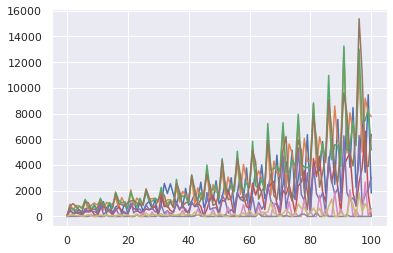

0

In [87]:
environnement_test.initialise(price=0.5, quality=100, promophile=5, sat_alpha=1, phi=0.3, c = 2, inertia = 2)
environnement_test.make_promo((0,40,(30,34),0,0))
environnement_test.run()
environnement_test.show_sales()

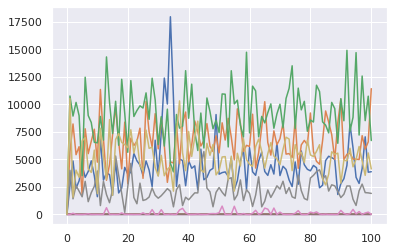

0

In [88]:
environnement_test.initialise(price=2, quality=0, promophile=5, sat_alpha=100, phi=0.3, c = 2, inertia = 0)
environnement_test.make_promo((0,40,(30,34),0,0))
environnement_test.run()
environnement_test.show_sales()

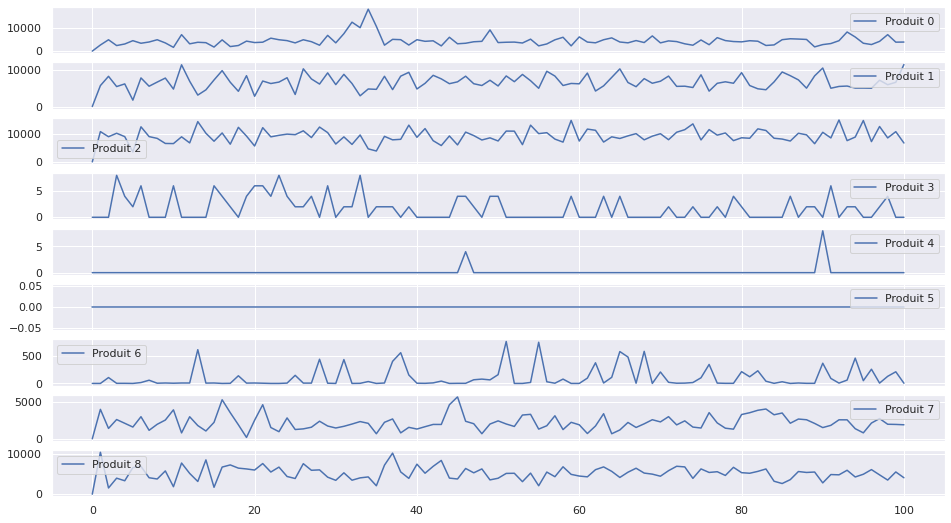

0

In [89]:
environnement_test.show_sales_separated()

La qualité n'ayant plus d'impact on observe que certains produits (les plus cher) ne sont plus du tout achetés 